<a href="https://colab.research.google.com/github/JJPhoenix/CourtCounter/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Base de datos Banking

# 1. Introducción
Los bancos estan encardos de prestar diferentes servicios a los clientes, estos servicios tales como planes de deposito, cuentas de ahorros, prestamos, etc. Uno de los mecanimos de captación de clientes el marketing por telefono(**tele-marketing**); este consiste en realizar llamadas a sus potenciales clientes con el objetivo de ofrecer los productos del banco para que estos puedan adquirirlos.

En el presente trabajo analizaremos un conjuto de datos(**dataset**) proporcionados por un campaña de tele-marketing realizada por una institución bancaria portuguesa; esta contiene información de los potenciales clientes como su decision a la pregunta de apertura de deposito a plazo.

El objetivo de este analisis es predecir si el potencial cliente se suscribirá a un depósito a plazo (**variable y**) o no.

## Importando las librerías a usar


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install sweetviz

import sweetviz as sv

## Utils

In [ ]:
def print_msg(msg, color = 'verde'):
  code = ''
  if color == 'rojo' :
    code='\033[91m'
  elif color == 'amarillo':
    code ='\033[93m'
  elif color == 'verde':
    code ='\033[92m'
  print(code + '\n' + msg )


# 2. Pre-procesamiento de datos
Antes de iniciar con la creación del modelo nuestro equipo se encargará de cargar la data y pre-procesarla. Este paso es muy importante para evitar errores en nuestro modelo.

## Descargar data sets CSV
En este primer paso cargaremos el dataset del caso descrito en la introducción. A continuación mostraremos una breve descripción de los atributos cargados en nuestro dataset.

**Input variables:**

1. age (numeric)
2. job : tipo de trabajo (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : estado marital (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education: nivel de educación (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: Tiene credito? (categorical: 'no','yes','unknown')
6. housing: tiene prestamo de vivienda? (categorical: 'no','yes','unknown')
7. loan: tiene prestamo personal? (categorical: 'no','yes','unknown')
8. contact: tipo de contacto (categorical: 'cellular','telephone')
9. month: ultimo mes de contacto del año (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: ultimo dia de contacto(categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
12. campaign: número de contactos realizados durante esta campaña y para este cliente(numeric, includes last contact)
13. pdays: número de días que pasaron después de que el cliente fue contactado por última vez de una campaña anterior(numeric; 999 means client was not previously contacted)
14. previous: número de contactos realizados antes de esta campaña y para este cliente (numeric)
15. poutcome: resultado de la campaña de marketing anterior(categorical: 'failure','nonexistent','success')

**Output variable** (Variable de salida):

21. y.: ¿La cliente ha suscrito un depósito a plazo? (binary: 'yes','no')

Segun la documentación del dataset, se recomienda la eliminación del campo "duration" debido a que este campo se obtiene luego de que la llamada se termine, no antes. Esta descripcion hace que este dato se considere con un 'data leakage' que no ayuda a la predicción de los modelos.

In [ ]:
# carga de datos de bank_full
bank_full = pd.read_csv('https://drive.google.com/uc?export=download&id=1QO8I0W5Ycg-ZEwHImRB_wY6JQemRnz_s',sep=';')

# carga de datos de bank
bank = pd.read_csv('https://drive.google.com/uc?export=download&id=1eREPr1qNiAZWmiVlgHV3_rZ4AV7qyCHX',sep=';')

# Eliminar el campo duration de bank_full
bank_full = bank_full.drop('duration', axis=1)

# Eliminar el campo duration de bank
bank = bank.drop('duration',axis=1)

In [ ]:
print(bank_full.shape)
bank_full.head()

(45211, 16)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


In [ ]:
print(bank.shape)
bank.head()

(4521, 16)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,1,-1,0,unknown,no


## Valores nulos o faltantes
Continuando con el analisis de los datos, verificaremos si existen valores nulos o faltantes. Esta falta de datos o datos nulos tienen diferentes causas; aunque la mas comun es la humana, por ello se hace este analisis antes de usar el dataset en un modelo.

Para realizar esta verificación usaremos la función `is_null()` de la libreria Pandas, y usaremos la función `sum()` para ver el total de valores nulos o faltantes por cada campo.

In [8]:
# valores faltantes dentro del dataset bank_full
bank_full.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [9]:
# valores faltantes dentro del dataset bank
bank.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Como se puede observar no existen valores faltantes dentro de la data proporcionada por el banco. **Debido a esto podemos continuar sin realizar alguna modificación por causa de datos faltantes o nulos.**

## Analizando la data

In [ ]:
# hacemos una copia de bank_full
df = bank_full.copy()
df_test= bank.copy()

In [ ]:
# Analizamos si no tiene nulos como lo mencionó el data set además del tipo de
# dato
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## Analizaremos mediante gráficas

/usr/local/lib/python3.10/dist-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/usr/local/lib/python3.10/dist-packages/sweetviz/dataframe_report.py:92: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_compare_names = [cur_name for cur_name, cur_series in compare_df.iteritems()]
/usr/local/lib/python3.10/dist-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |          | [  0%]   00:00 -> (? left)

/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/usr/local/lib/python3.1


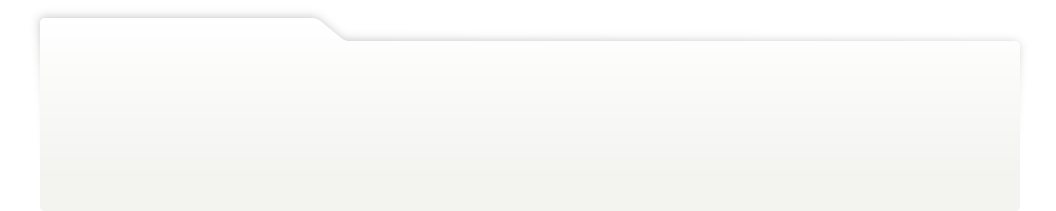
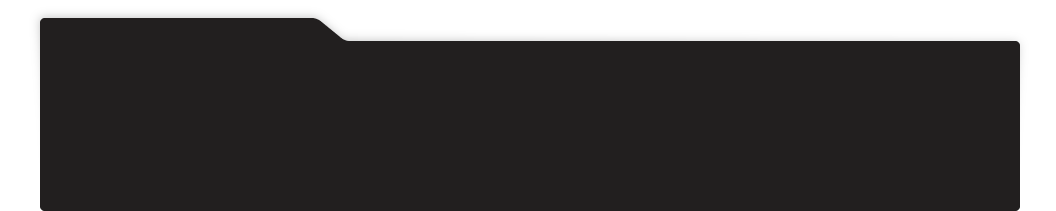
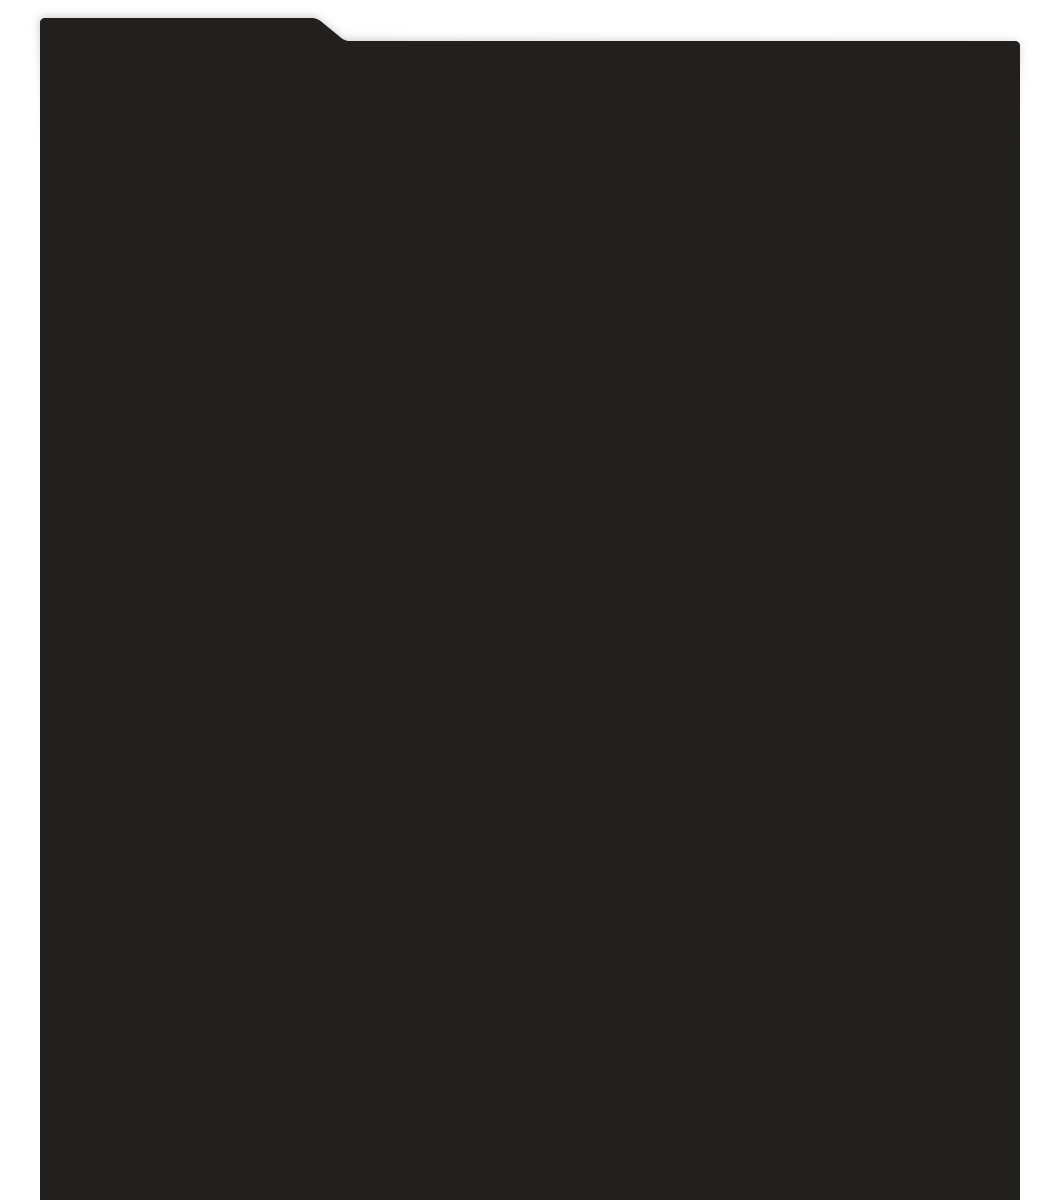
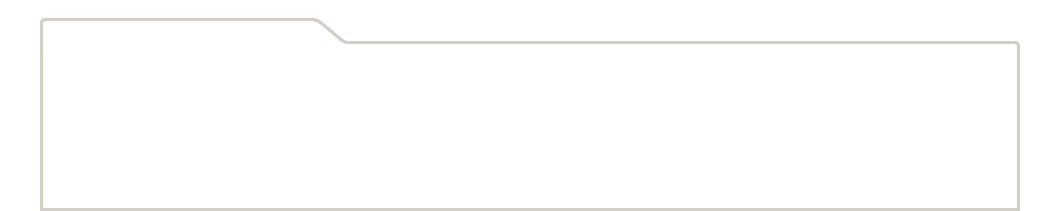
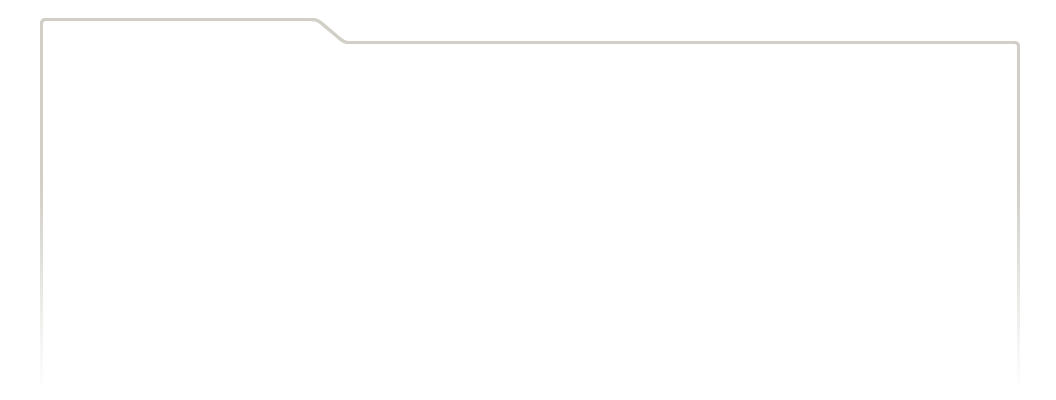
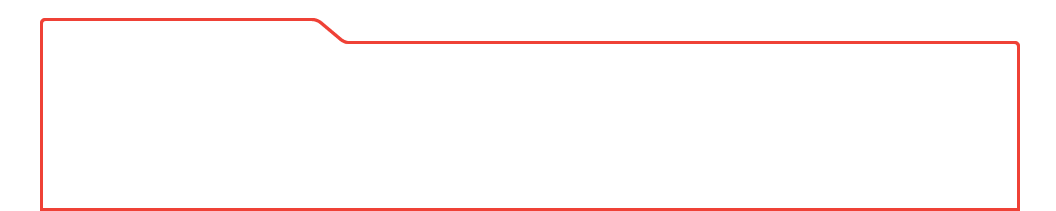
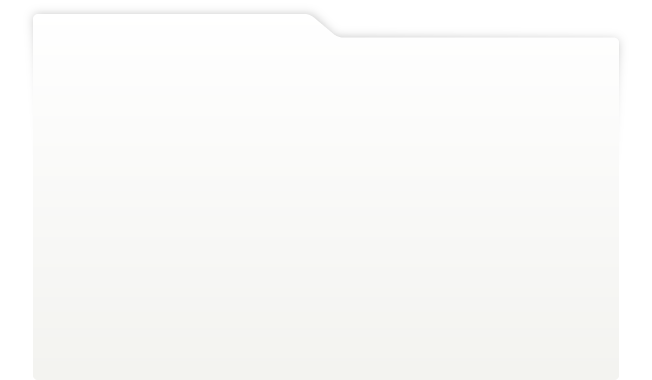
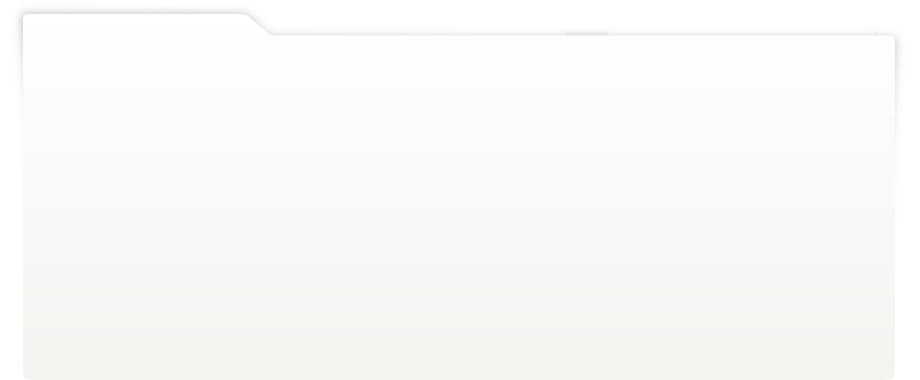
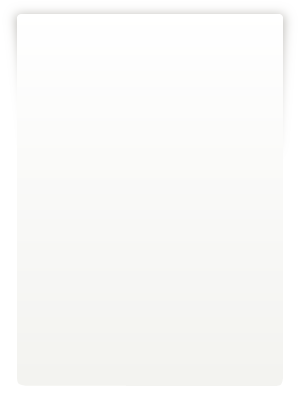
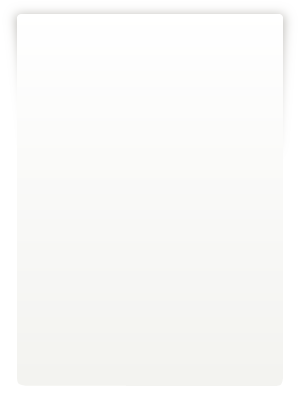
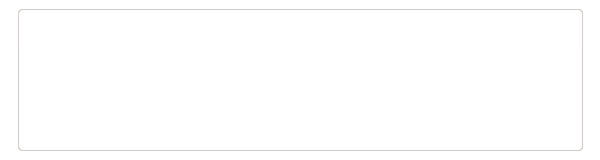
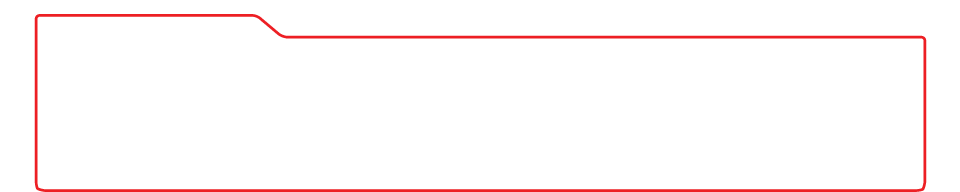
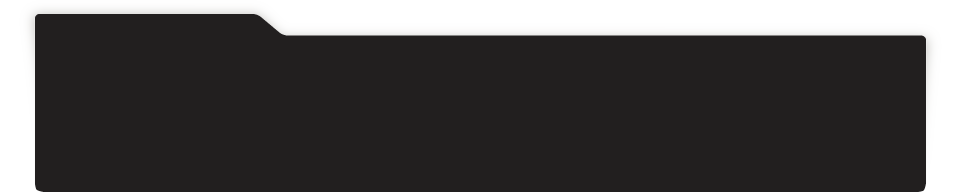
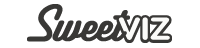
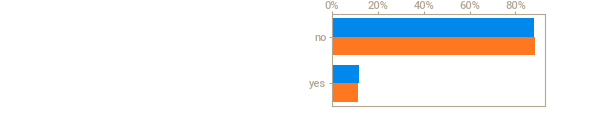
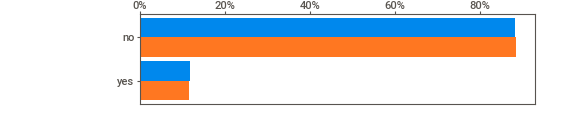
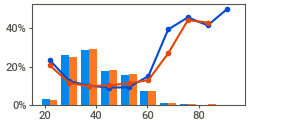
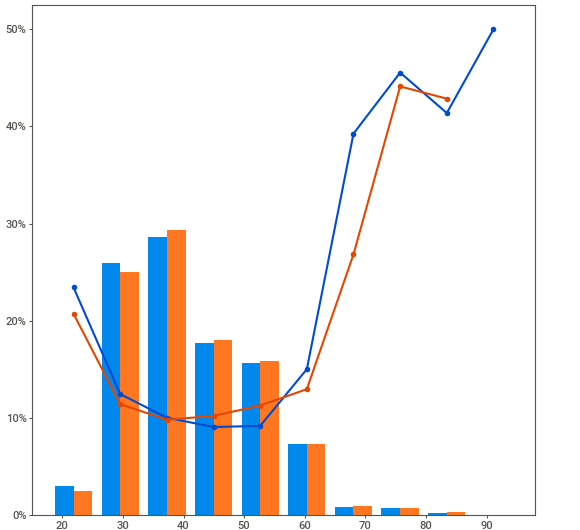
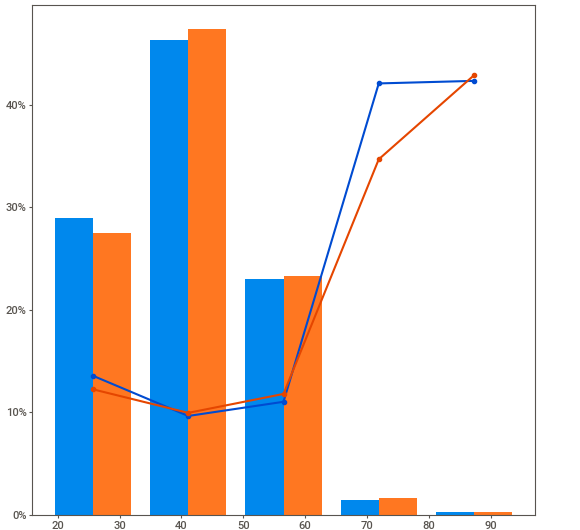
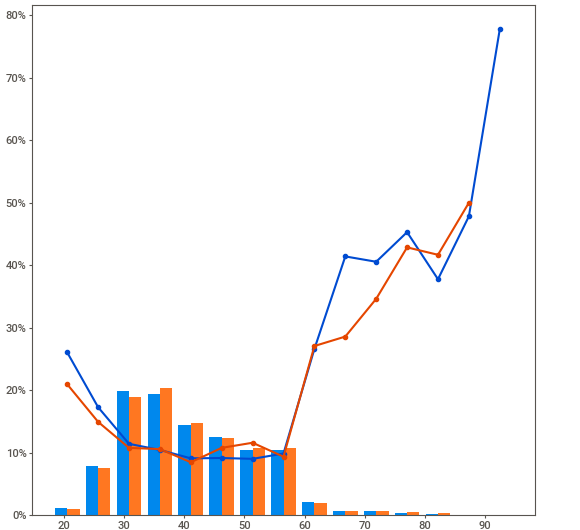
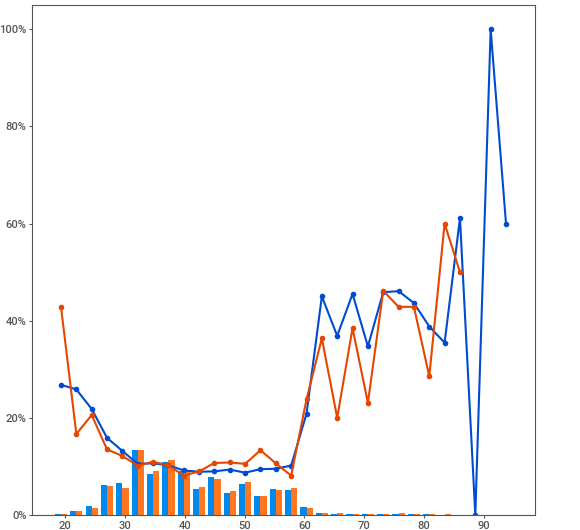
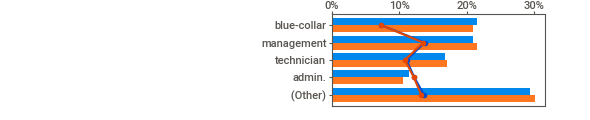
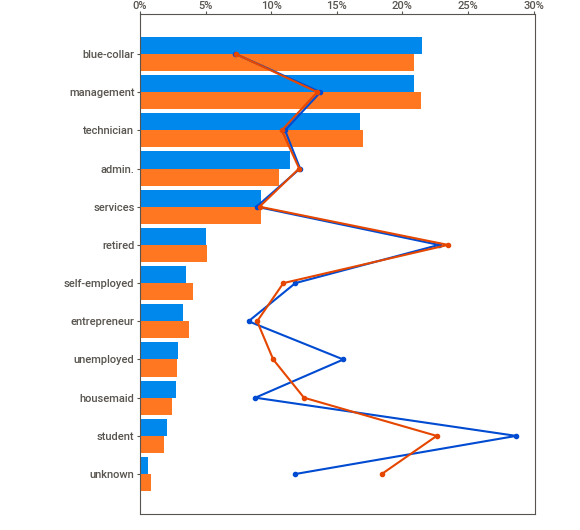
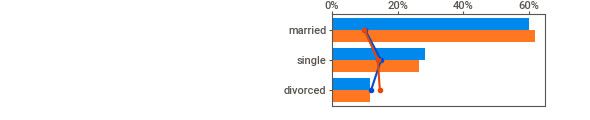
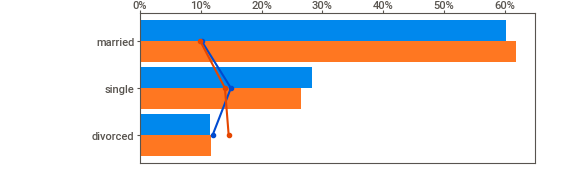
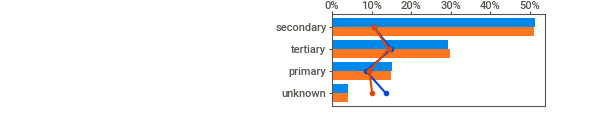
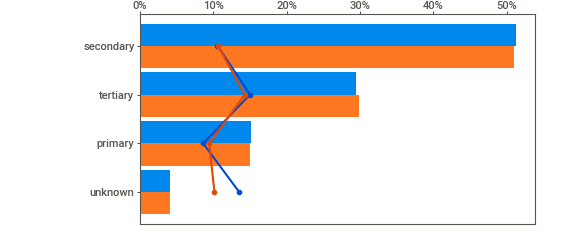
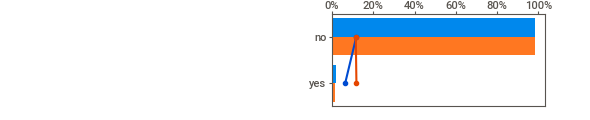
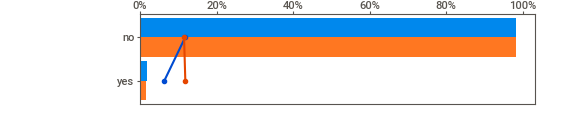
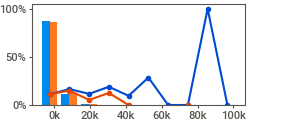
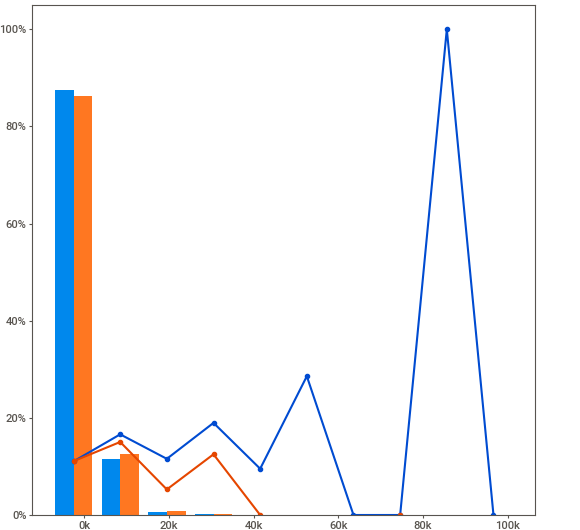
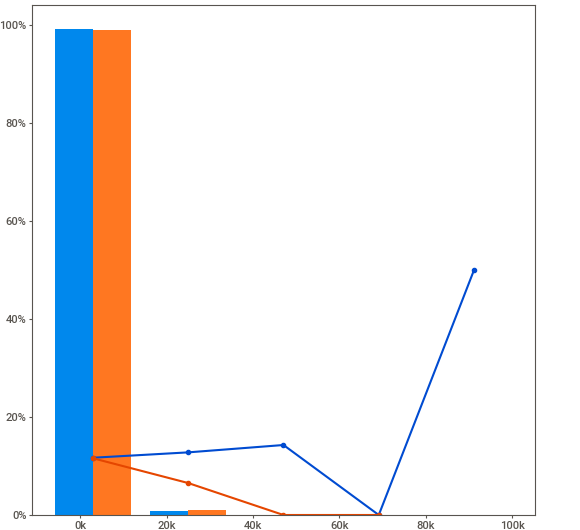
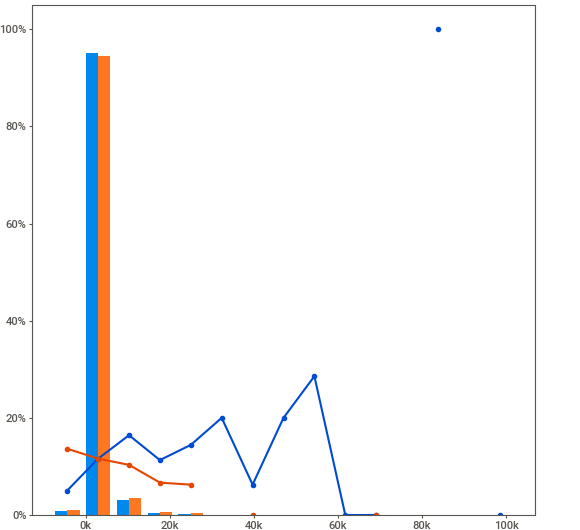
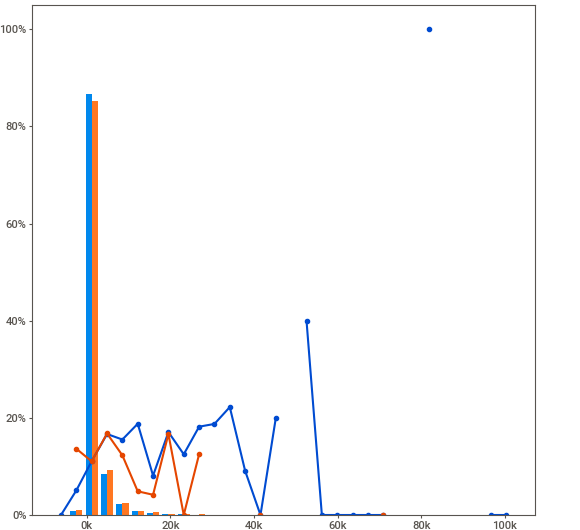
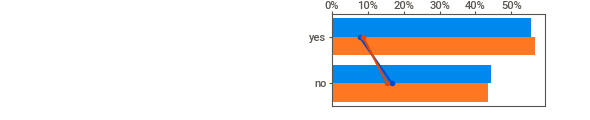
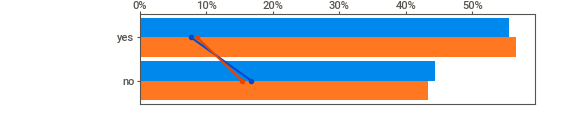
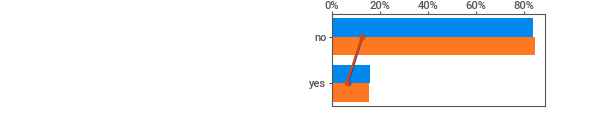
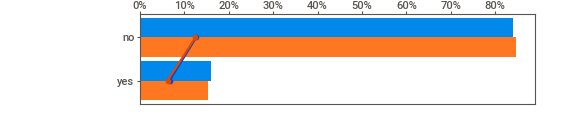
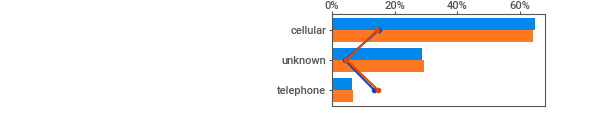
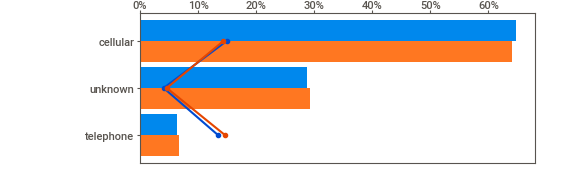
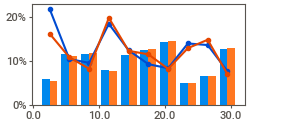
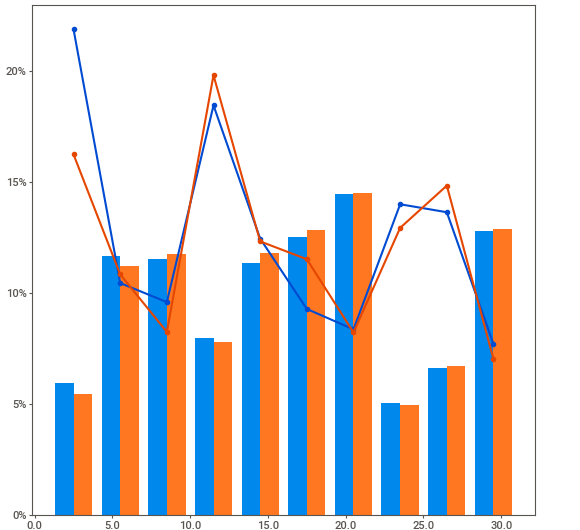
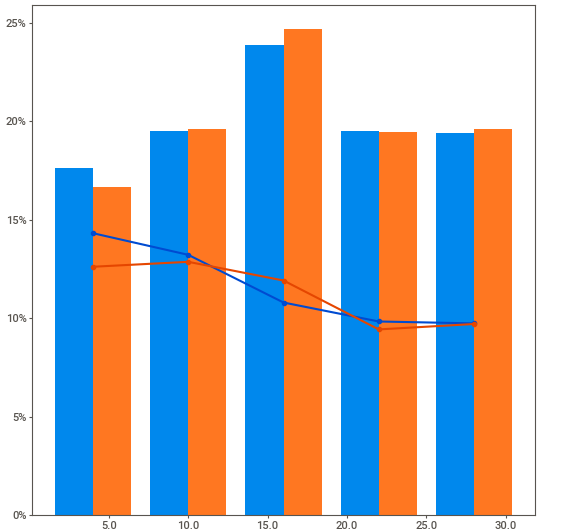
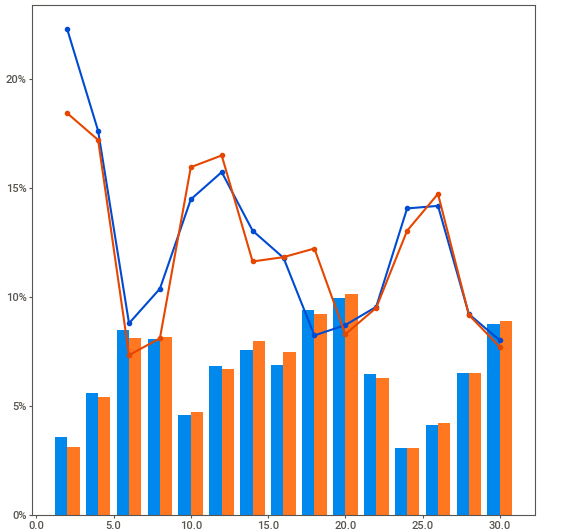
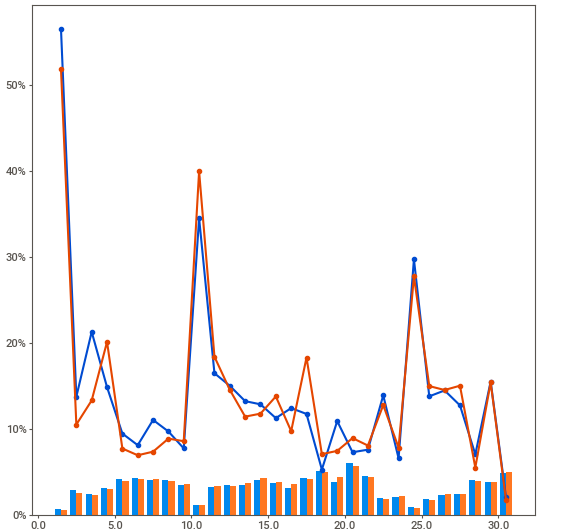
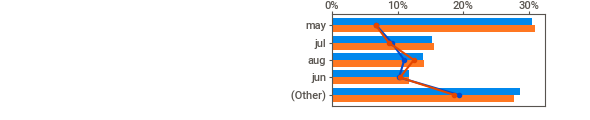
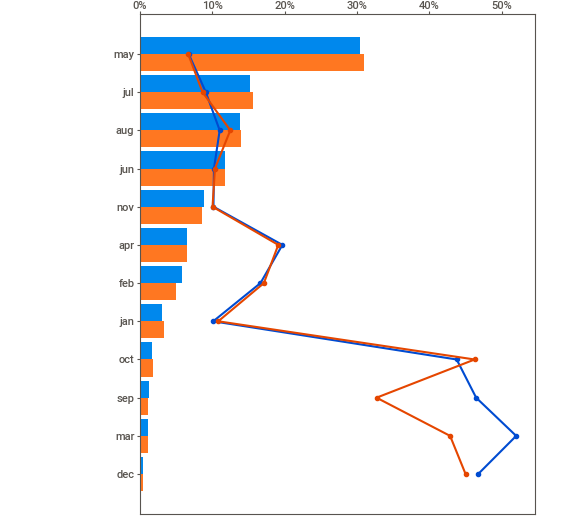
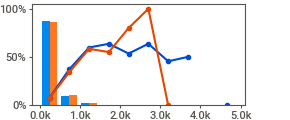
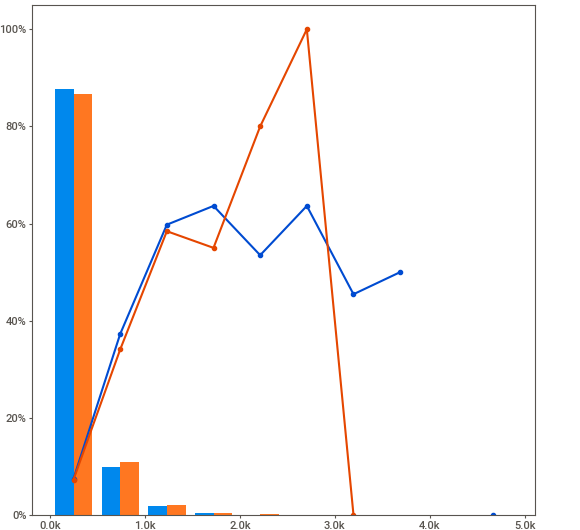
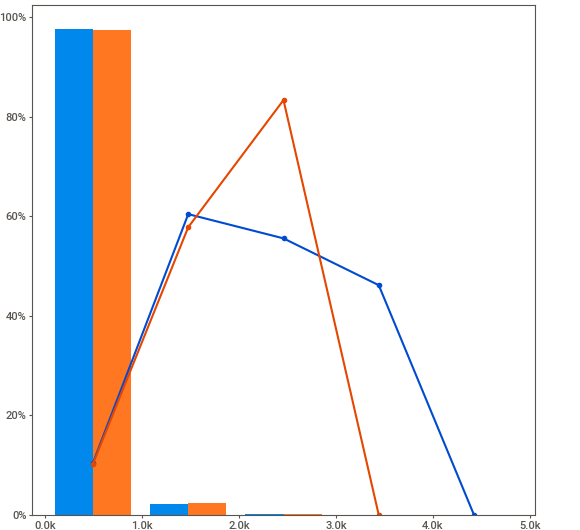
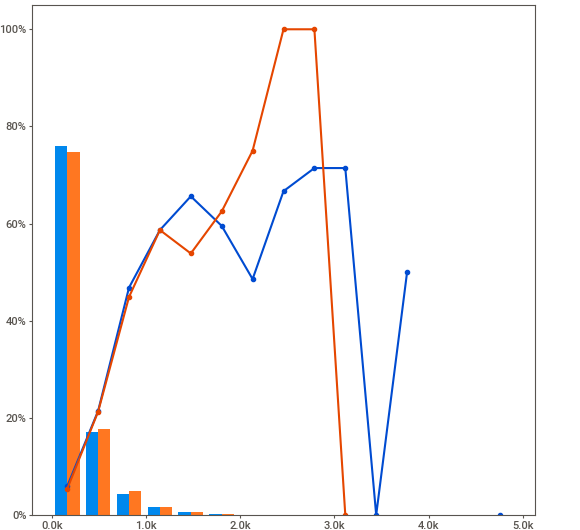
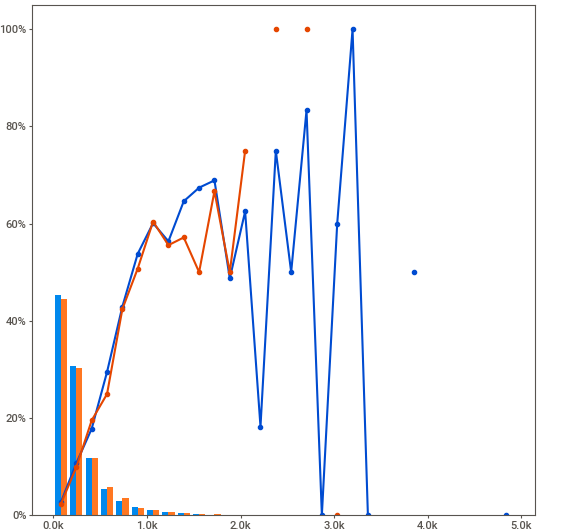
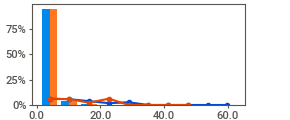
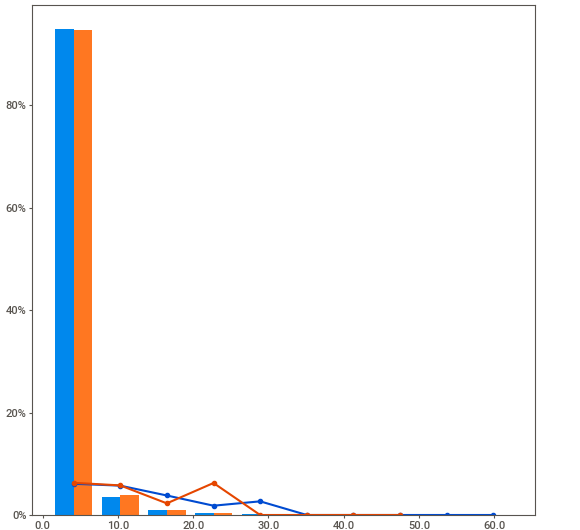
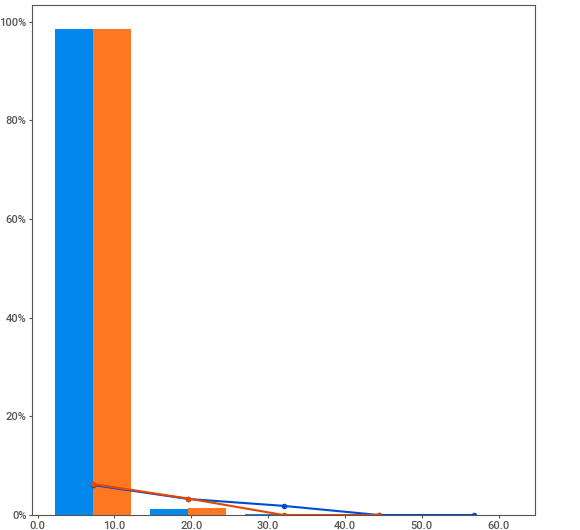
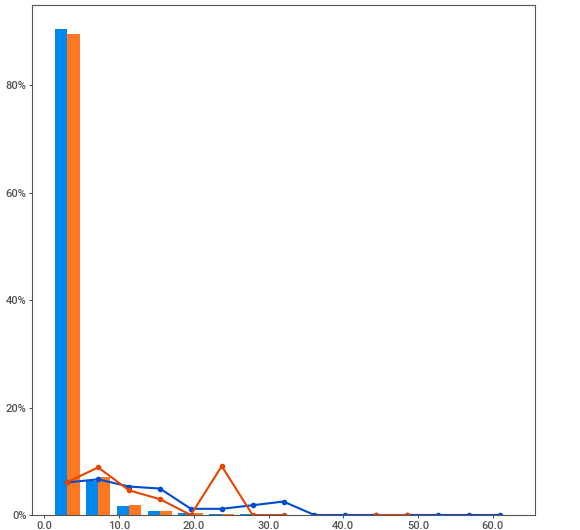
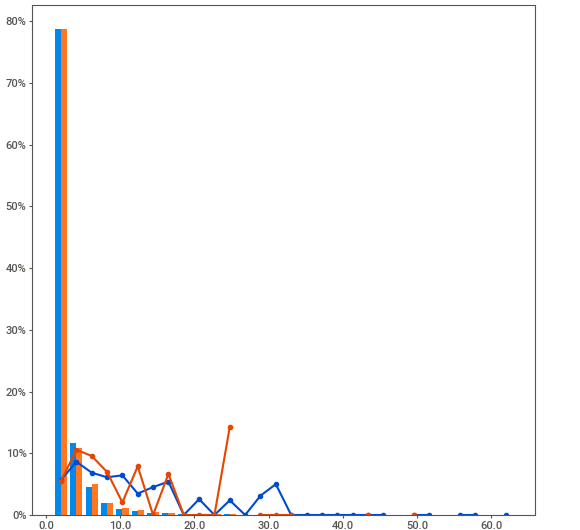
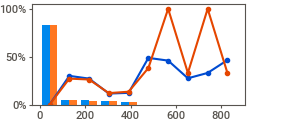
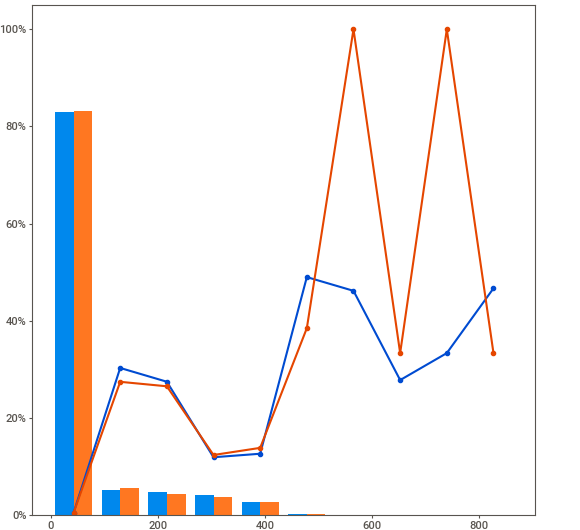
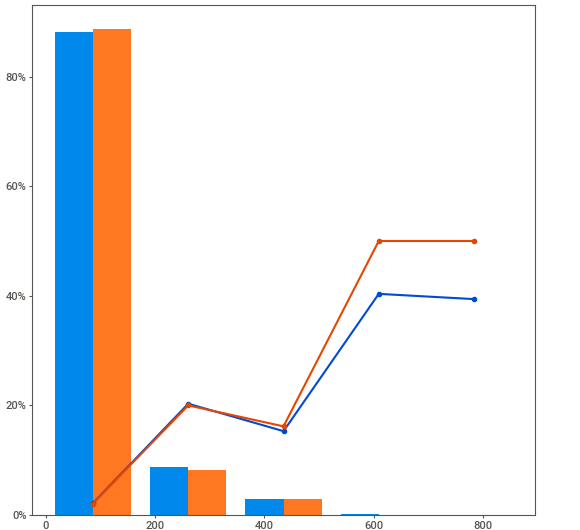
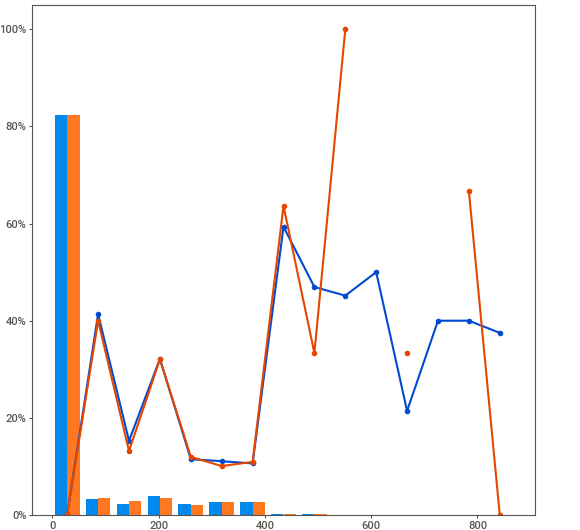
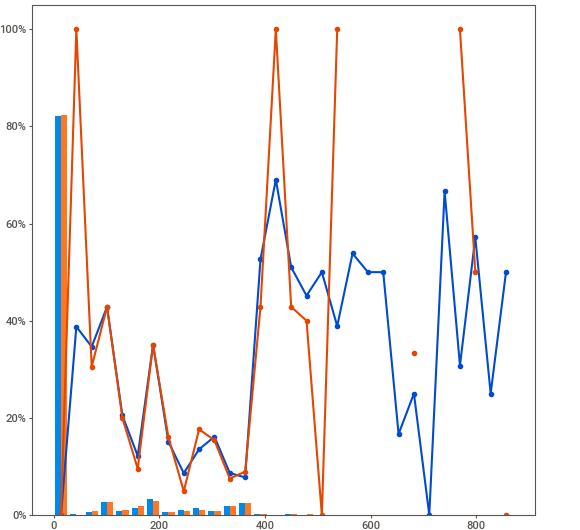
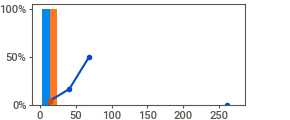
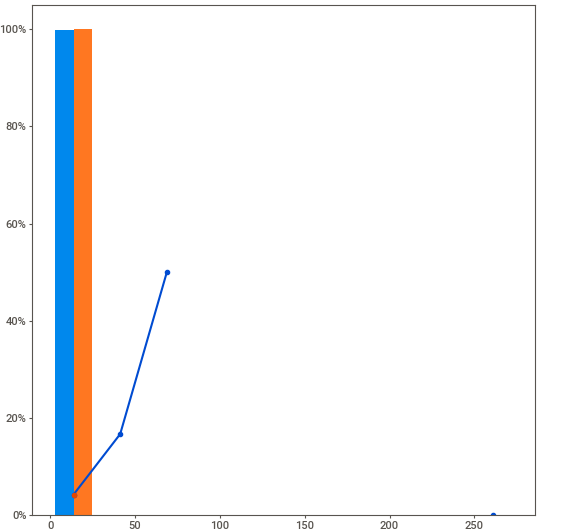
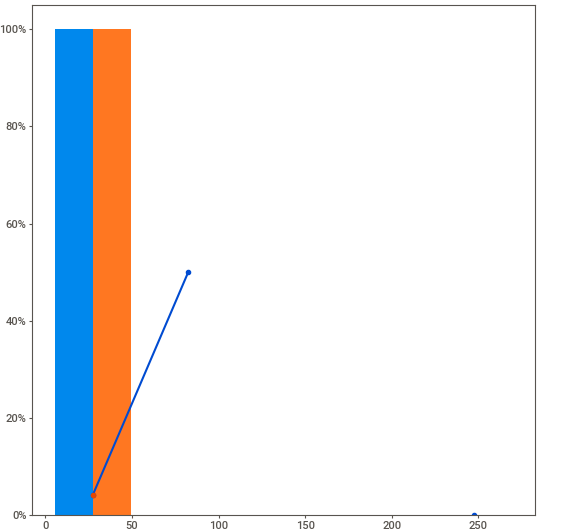
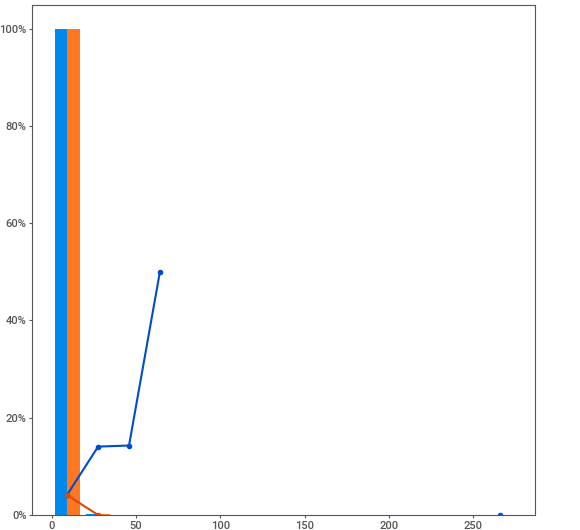
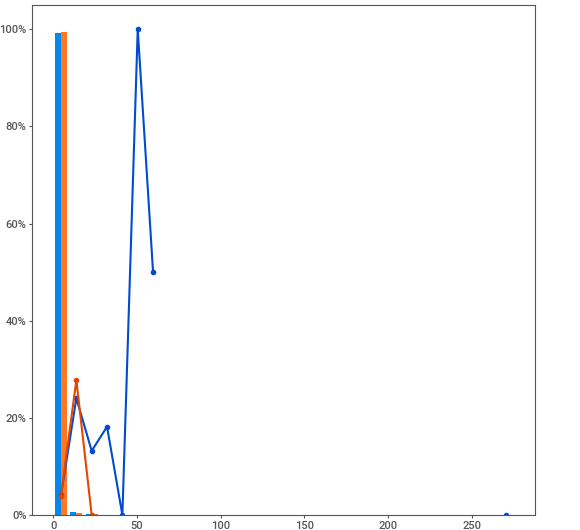
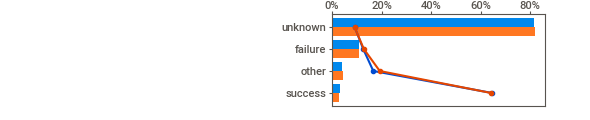
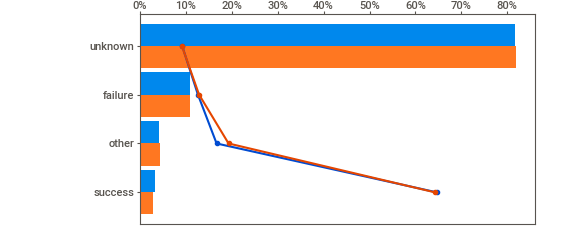
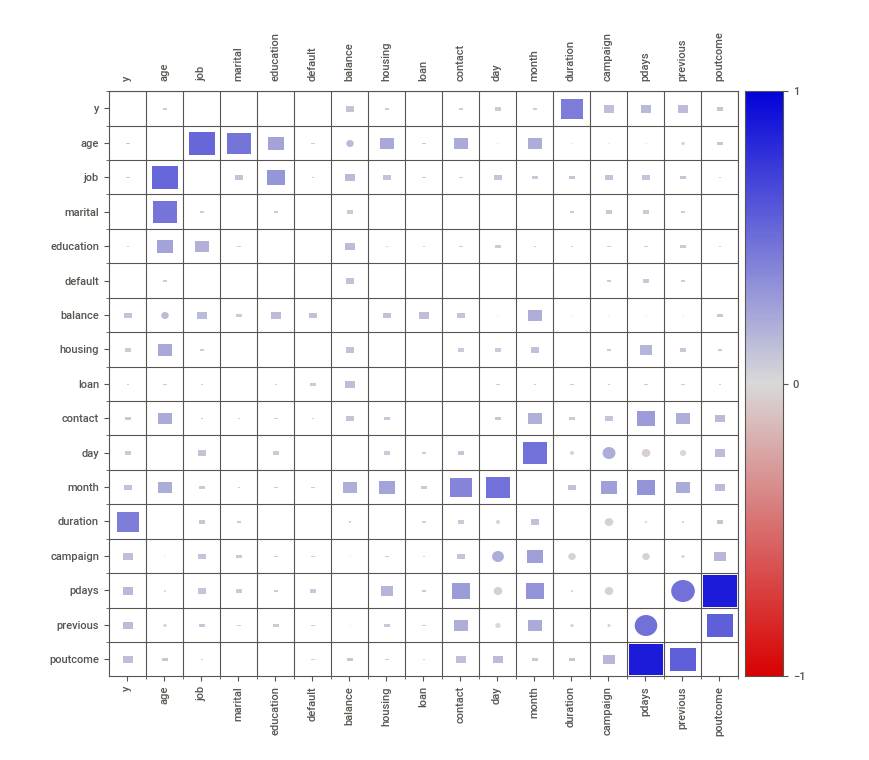
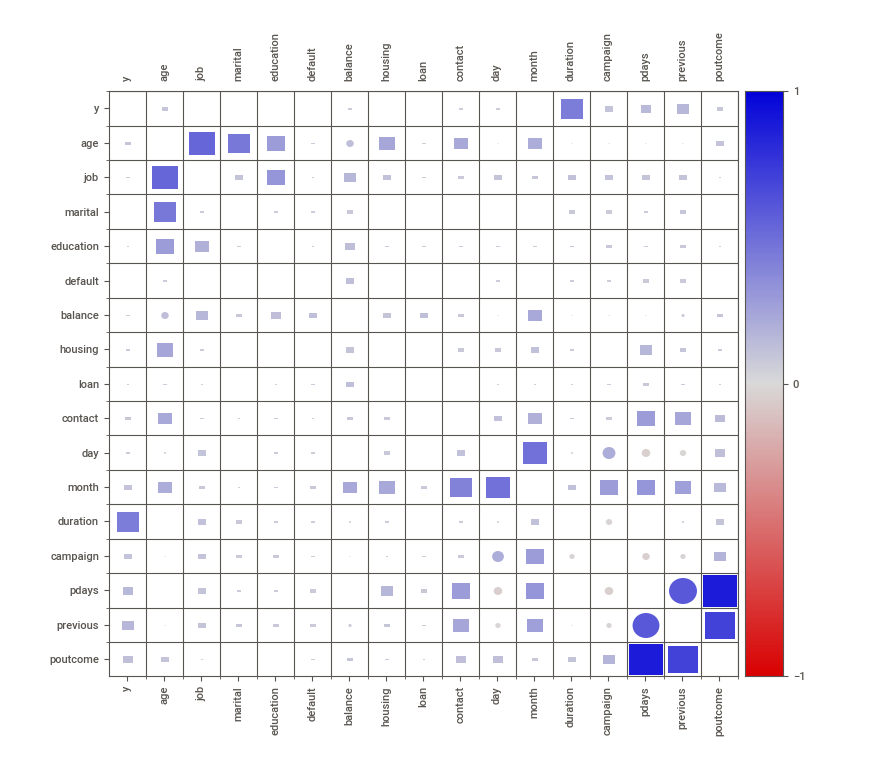

In [ ]:
comparison_report = sv.compare([bank_full,'Train'], [bank,'Test'], target_feat='y')
comparison_report.show_notebook()

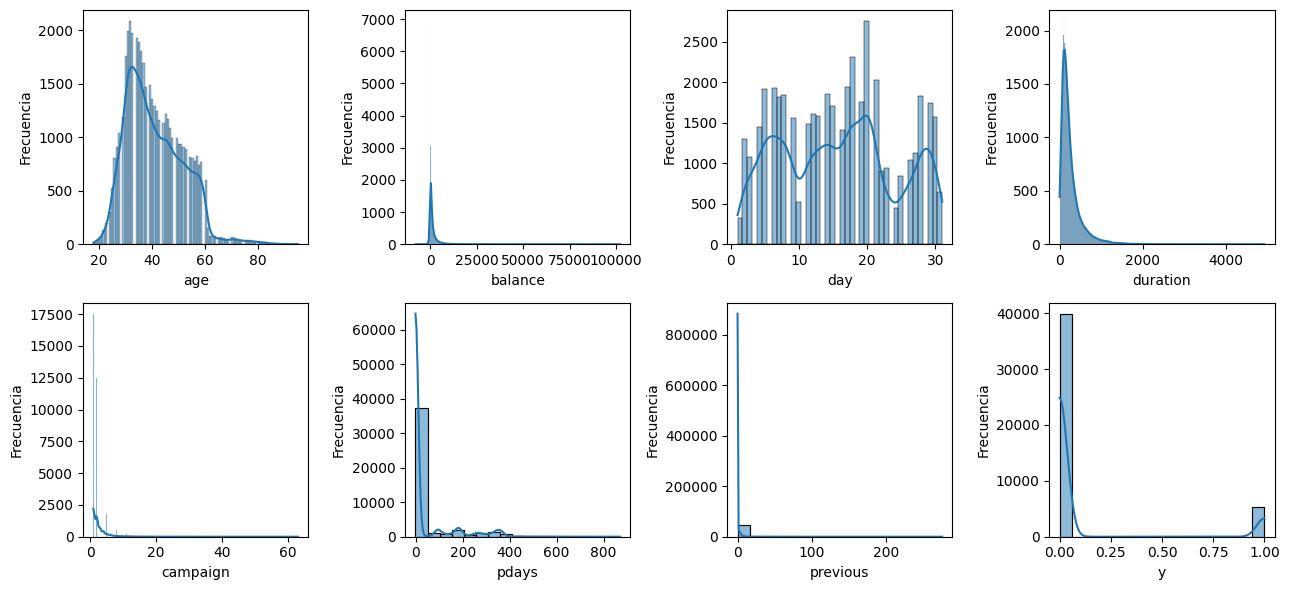

In [ ]:
#Frecuencia de datos
df_numeric = df.select_dtypes(include=['int64', 'float64'])
figure, axes = plt.subplots(nrows=2, ncols=4, figsize=(13, 6))

for column, axe in zip(df_numeric, axes.flatten()):
    sns.histplot(df_numeric[column], ax=axe, kde=True)
    axe.set_xlabel(column)
    axe.set_ylabel('Frecuencia')

plt.tight_layout()

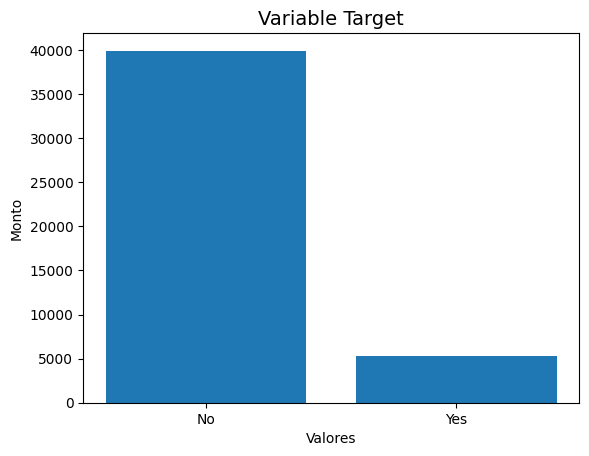


La variable objetivo está sumamente desequilibrado, y sabiendo que la variable y con el valor yes es lo que deseamos la predicción saldría erronea

Despues tendremos que usar algun método para hacer algún equilibrio como undersamplig o oversampling


In [ ]:
# Analizamos la variable target
plt.bar(['No', 'Yes'], df.y.value_counts().values)
plt.title('Variable Target', fontsize=14)
plt.xlabel('Valores')
plt.ylabel('Monto')
plt.show()

print_msg('La variable objetivo está sumamente desequilibrado, y sabiendo que la variable y con el valor yes es lo que deseamos la predicción saldría erronea','rojo')
print_msg('Despues tendremos que usar algun método para hacer algún equilibrio como undersamplig o oversampling','amarillo')

In [ ]:
print_msg('remplazaremos con valores en booleanos','amarillo')
df.y.replace({'yes': 1, 'no': 0}, inplace=True)
df.y


remplazaremos con valores en booleanos


0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: y, Length: 45211, dtype: int64

In [ ]:
def campañas_suscritas(column):
  classes= df[column].value_counts().keys()
  percents = []
  column_with_percent = {}
  for class_value in classes:
    total = len(df[df[column]==class_value])

    percent_suscribed = df[df[column]==class_value].y.sum()/total
    percent_suscribed_before = df[(df.poutcome=='success') & (df.job==class_value)].y.sum()/total
    column_with_percent = {
        'columna' : class_value,
        'percent_suscribed' : percent_suscribed,
        'percent_suscribed_before' : percent_suscribed_before
    }
    percents.append(column_with_percent)
  return percents

In [ ]:
def print_msg_suscritos(suscritos):
  for suscrito in suscritos:
    print_msg('Porcentaje de la '+ str(suscrito['columna']) + ' en la campaña actual: {0:.0f}% '.format(suscrito['percent_suscribed']*100)+
          'y de la camapaña anterior  {0:.3f}%'.format(suscrito['percent_suscribed_before']*100),'amarillo')

In [ ]:
def graficar_suscritos(column,title):
  keys = df[column].value_counts().keys()
  plt.figure(figsize=(18,4))
  plt.bar(keys, df[column].value_counts().values, label=title)
  plt.bar(keys, [df[df[column]==key].y.sum() for key in keys], label='Suscritos')
  plt.bar(keys, [df[(df.poutcome=='success') & (df[column]==key)].y.sum() for key in keys], label='Suscritos anteriormente')
  plt.title(title)
  plt.xlabel(title)
  plt.ylabel('Cantidad')
  plt.legend()
  plt.show()

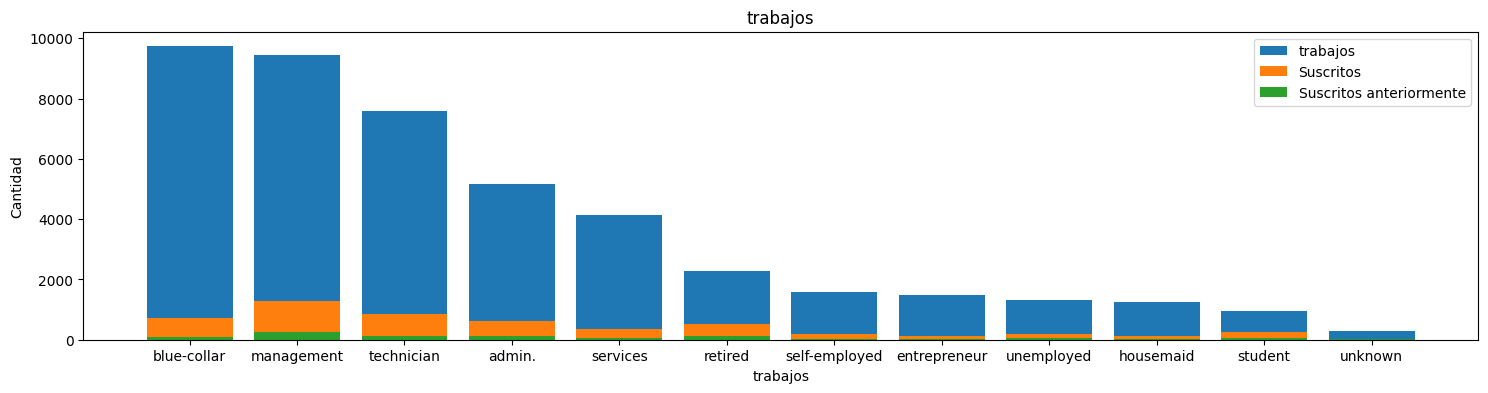


Porcentaje de la blue-collar en la campaña actual: 7% y de la camapaña anterior  0.873%

Porcentaje de la management en la campaña actual: 14% y de la camapaña anterior  2.812%

Porcentaje de la technician en la campaña actual: 11% y de la camapaña anterior  1.817%

Porcentaje de la admin. en la campaña actual: 12% y de la camapaña anterior  2.359%

Porcentaje de la services en la campaña actual: 9% y de la camapaña anterior  1.420%

Porcentaje de la retired en la campaña actual: 23% y de la camapaña anterior  5.521%

Porcentaje de la self-employed en la campaña actual: 12% y de la camapaña anterior  2.280%

Porcentaje de la entrepreneur en la campaña actual: 8% y de la camapaña anterior  0.605%

Porcentaje de la unemployed en la campaña actual: 16% y de la camapaña anterior  3.837%

Porcentaje de la housemaid en la campaña actual: 9% y de la camapaña anterior  1.371%

Porcentaje de la student en la campaña actual: 29% y de la camapaña anterior  6.610%

Porcentaje de la unknown en la 

In [ ]:
graficar_suscritos('job', 'trabajos')
print_msg_suscritos(campañas_suscritas('job'))
print_msg('De esto podemos deducir que en la campaña actual que los estudiantes son los que más aceptaron las campañas tanto actual como la anterior')

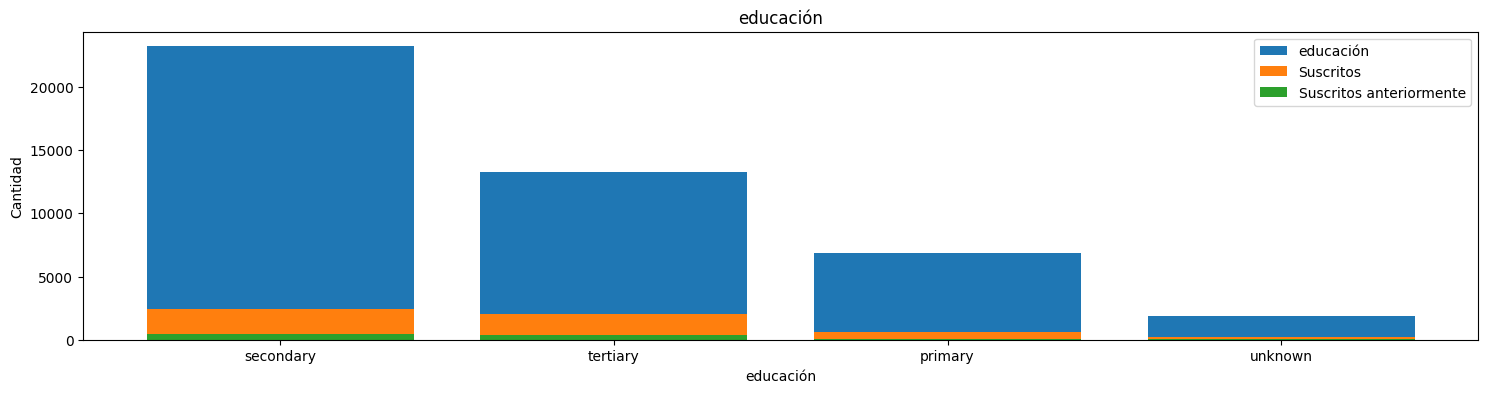


Porcentaje de la secondary en la campaña actual: 11% y de la camapaña anterior  0.000%

Porcentaje de la tertiary en la campaña actual: 15% y de la camapaña anterior  0.000%

Porcentaje de la primary en la campaña actual: 9% y de la camapaña anterior  0.000%

Porcentaje de la unknown en la campaña actual: 14% y de la camapaña anterior  0.485%

De esto podemos deducir que en la campaña actual que los que cuentan con educación tertiary son los que más aceptaron las campañas tanto actual como la anterior


In [ ]:
graficar_suscritos('education', 'educación')
print_msg_suscritos(campañas_suscritas('education'))
print_msg('De esto podemos deducir que en la campaña actual que los que cuentan con educación tertiary son los que más aceptaron las campañas tanto actual como la anterior')

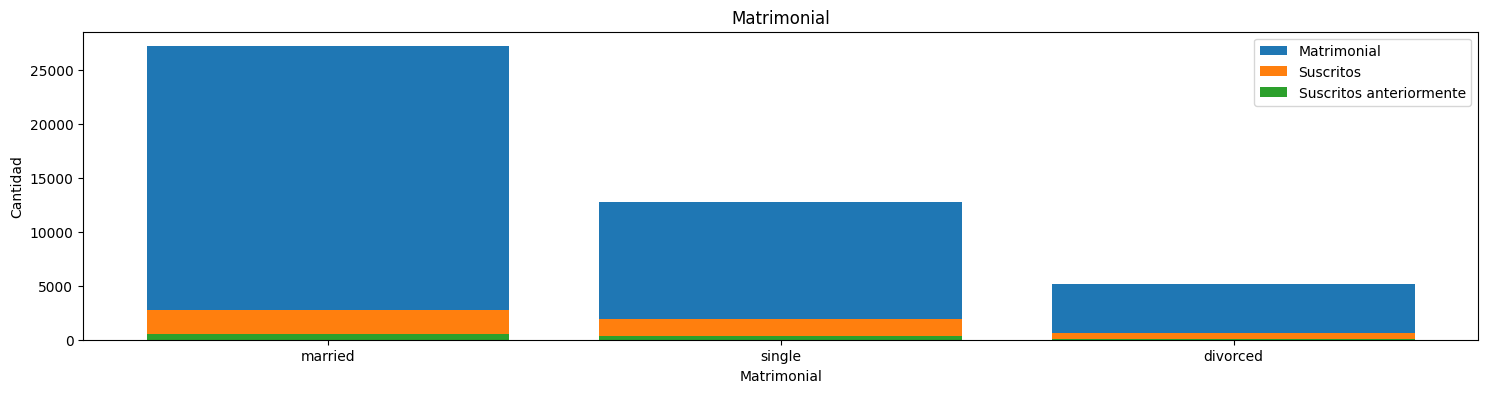


Porcentaje de la married en la campaña actual: 10% y de la camapaña anterior  0.000%

Porcentaje de la single en la campaña actual: 15% y de la camapaña anterior  0.000%

Porcentaje de la divorced en la campaña actual: 12% y de la camapaña anterior  0.000%

De esto podemos deducir que en la campaña actual que los solteros son los que más aceptaron las campañas


In [ ]:
graficar_suscritos('marital', 'Matrimonial')
print_msg_suscritos(campañas_suscritas('marital'))
print_msg('De esto podemos deducir que en la campaña actual que los solteros son los que más aceptaron las campañas')


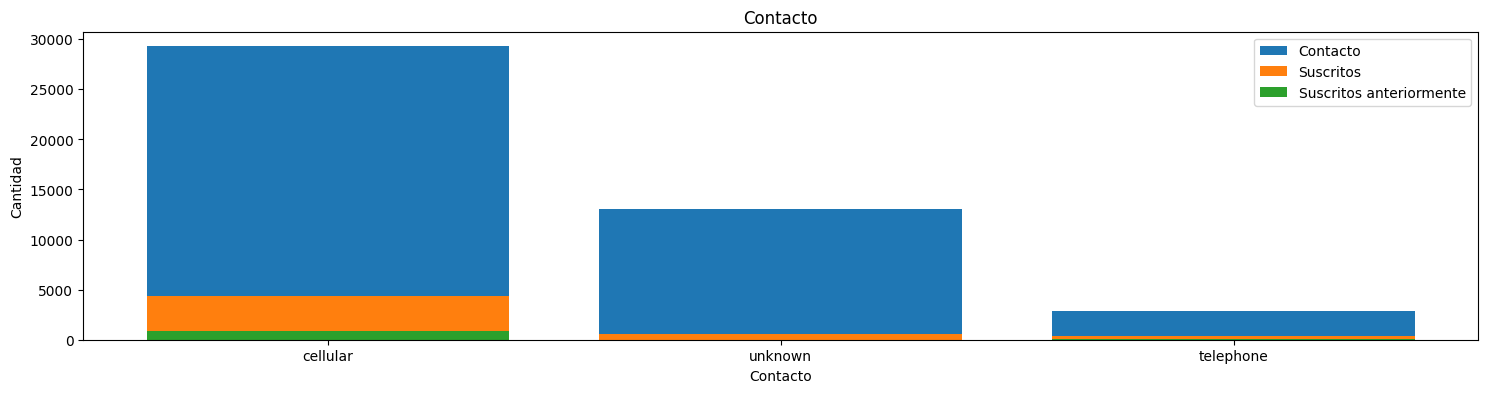


Porcentaje de la cellular en la campaña actual: 15% y de la camapaña anterior  0.000%

Porcentaje de la unknown en la campaña actual: 4% y de la camapaña anterior  0.069%

Porcentaje de la telephone en la campaña actual: 13% y de la camapaña anterior  0.000%

De esto podemos que las campaña actual fue más exitosa por celular y teléfono, pero en la campaña anterior se tuvo un porcentaje de los desconocidos


In [ ]:
graficar_suscritos('contact', 'Contacto')
print_msg_suscritos(campañas_suscritas('contact'))
print_msg('De esto podemos que las campaña actual fue más exitosa por celular y teléfono, pero en la campaña anterior se tuvo un porcentaje de los desconocidos')



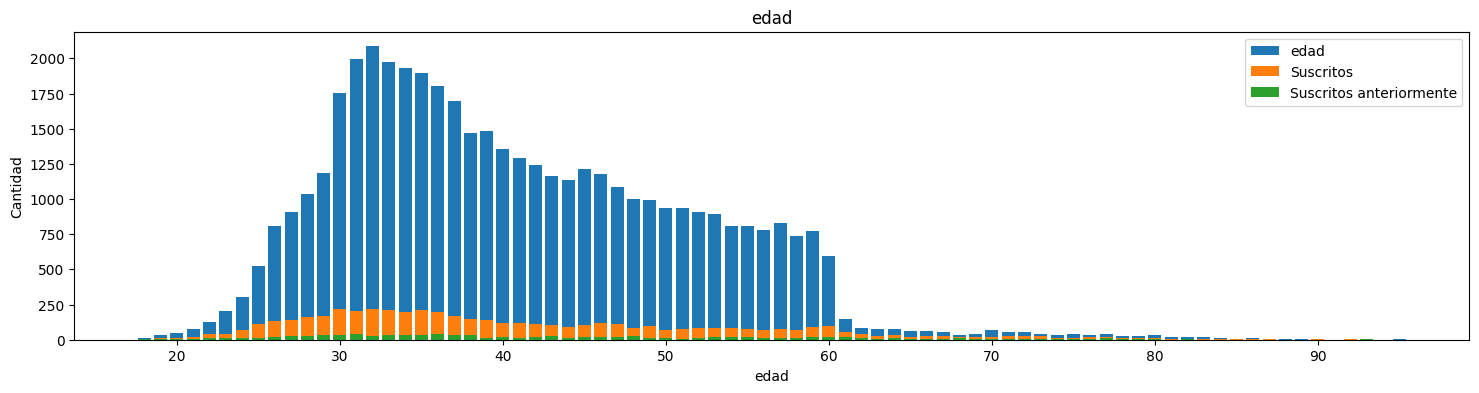


antes de 60: 10.8% de suscriptores

despues de 60: 42.26% suscriptores


In [ ]:
graficar_suscritos('age', 'edad')
# print_msg_suscritos(campañas_suscritas('age'))
menor_60 = round((df[df.age < 60].y.sum()/sum(df.age < 60))*100, 2)
mas_60 = round((df[df.age > 60].y.sum()/sum(df.age > 60))*100, 2)
print_msg('antes de 60: {}% de suscriptores'.format(menor_60))
print_msg('despues de 60: {}% suscriptores'.format(mas_60))



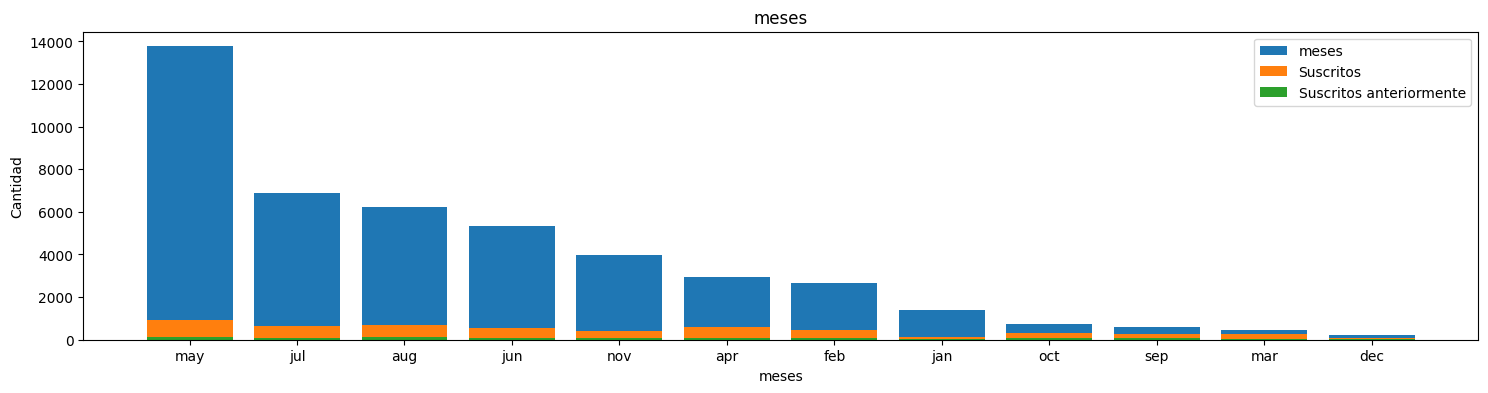


Porcentaje de la may en la campaña actual: 7% y de la camapaña anterior  0.000%

Porcentaje de la jul en la campaña actual: 9% y de la camapaña anterior  0.000%

Porcentaje de la aug en la campaña actual: 11% y de la camapaña anterior  0.000%

Porcentaje de la jun en la campaña actual: 10% y de la camapaña anterior  0.000%

Porcentaje de la nov en la campaña actual: 10% y de la camapaña anterior  0.000%

Porcentaje de la apr en la campaña actual: 20% y de la camapaña anterior  0.000%

Porcentaje de la feb en la campaña actual: 17% y de la camapaña anterior  0.000%

Porcentaje de la jan en la campaña actual: 10% y de la camapaña anterior  0.000%

Porcentaje de la oct en la campaña actual: 44% y de la camapaña anterior  0.000%

Porcentaje de la sep en la campaña actual: 46% y de la camapaña anterior  0.000%

Porcentaje de la mar en la campaña actual: 52% y de la camapaña anterior  0.000%

Porcentaje de la dec en la campaña actual: 47% y de la camapaña anterior  0.000%

De esto podemos d

In [ ]:
graficar_suscritos('month', 'meses')
print_msg_suscritos(campañas_suscritas('month'))
print_msg('De esto podemos decir que en el mes de marzo fue donde la camapaña más eficiente')


## Limpieza de datos

# 3. Modelamiento